In [ ]:
!pip install pyLDAvis==3.4.1
!pip install tdqm
!pip install detoxify

In [ ]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import os

import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.figure_factory as ff

import re

from tqdm import tqdm

#nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


import pyLDAvis
pyLDAvis.enable_notebook()

from detoxify import Detoxify
toxicity_model = Detoxify('original')

In [3]:
with open('before_war_vect.pkl', 'rb') as f:
    before_war_vect = pickle.load(f)
with open('war_and_after_vect.pkl', 'rb') as f:
    war_and_after_vect = pickle.load(f)

with open('before_war_sample.pkl', 'rb') as f:
    before_war_sample = pickle.load(f)
with open('war_and_after_sample.pkl', 'rb') as f:
    war_and_after_sample = pickle.load(f)

with open('before_war_tfidf.pkl', 'rb') as f:
    before_war_tfidf = pickle.load(f)
with open('war_and_after_tfidf.pkl', 'rb') as f:
    war_and_after_tfidf = pickle.load(f)

#get the LDA models for before and after
with open('before_war_lda.pkl', 'rb') as f:
    before_war_lda = pickle.load(f)
with open('war_and_after_lda.pkl', 'rb') as f:
    war_and_after_lda = pickle.load(f)


#get the LDA models for before and after
with open('before_war_lda.pkl', 'rb') as f:
    before_war_lda = pickle.load(f)
with open('war_and_after_lda.pkl', 'rb') as f:
    war_and_after_lda = pickle.load(f)


with open('before_war_ngrams.pkl', 'rb') as f:
    before_war_ngrams = pickle.load(f)

with open('war_and_after_ngrams.pkl', 'rb') as f:
    war_and_after_ngrams = pickle.load(f)

with open('before_war_ngram_tox_dict.pkl', 'rb') as f:
    before_war_ngram_tox_dict = pickle.load(f)

with open('war_and_after_ngram_tox_dict.pkl', 'rb') as f:
    war_and_after_ngram_tox_dict = pickle.load(f)

In [25]:
#Below we get the sum of toxicity scores for each ngram in topic.
before_war_topics_all_ngrams = dict()
before_feature_names = before_war_vect.get_feature_names_out()
for topic_idx, topic in enumerate(before_war_lda.components_):
    before_war_topics_all_ngrams[topic_idx] = [before_feature_names[i] for i in topic.argsort()]

after_war_topics_all_ngrams = dict()
after_war_feature_names = war_and_after_vect.get_feature_names_out()
for topic_idx, topic in enumerate(war_and_after_lda.components_):
    after_war_topics_all_ngrams[topic_idx] = [after_war_feature_names[i] for i in topic.argsort()[::-1]]

n_top_words = 20
tf_feature_names = war_and_after_vect.get_feature_names_out()
top_20_words = dict()
for topic_idx, topic in enumerate(war_and_after_lda.components_):
    top_20_words[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]


#each toxicity_score in the values is no longer in list form
# before_war_ngram_tox_dict = {ngram: scores[0] for ngram, scores in before_war_ngram_tox_dict.items()}
# war_and_after_ngram_tox_dict = {ngram: scores[0] for ngram, scores in war_and_after_ngram_tox_dict.items()}



In [26]:
#simply extracting the avg alone.
topic_toxicity_totals = {}
topic_ngram_counts = {}
# Calculate total toxicity scores and ngram counts for each topic
for topic, ngrams in before_war_topics_all_ngrams.items():
    total_toxicity = sum(before_war_ngram_tox_dict.get(ngram, 0) for ngram in ngrams)
    print(total_toxicity)
    ngram_count = len(ngrams)
    topic_toxicity_totals[topic] = total_toxicity
    topic_ngram_counts[topic] = ngram_count

#calc avg
average_toxicity_scores = {}
for topic in before_war_topics_all_ngrams:
    average_toxicity_scores[topic] = topic_toxicity_totals[topic] / topic_ngram_counts[topic]

print(average_toxicity_scores)





152.05053390050307
152.05053390050307
152.05053390050307
152.05053390050307
152.05053390050307
152.05053390050307
152.05053390050307
152.05053390050307
152.05053390050307
{0: 0.030410106780100615, 1: 0.030410106780100615, 2: 0.030410106780100615, 3: 0.030410106780100615, 4: 0.030410106780100615, 5: 0.030410106780100615, 6: 0.030410106780100615, 7: 0.030410106780100615, 8: 0.030410106780100615}


In [13]:
topic_toxicity_stats = {}

#get each topic and its ngrams
for topic_idx, ngram_per_topic in before_war_topics_all_ngrams.items():
    # Initialize variables to store the statistics for the current topic
    total_toxicity = 0
    min_toxicity = float('inf')
    max_toxicity = float('-inf')
    ngram_toxicity_scores = []

    for ngram in ngram_per_topic:
        if ngram in before_war_ngram_tox_dict:
            toxicity_score = before_war_ngram_tox_dict[ngram][0]
            
            #
            total_toxicity += toxicity_score
            
            #update the min and max toxicity scores
            min_toxicity = min(min_toxicity, toxicity_score)
            max_toxicity = max(max_toxicity, toxicity_score)
            
            #append the score to the list for calculating the average later
            ngram_toxicity_scores.append(toxicity_score)
    
    #calc avg
    avg_toxicity = sum(ngram_toxicity_scores) / len(ngram_toxicity_scores) if ngram_toxicity_scores else 0
    
    #store in dict
    topic_toxicity_stats[topic_idx] = {
        'Min': min_toxicity,
        'Max': max_toxicity,
        'Average': avg_toxicity,
        'Total': total_toxicity
    }

topic_toxicity_stats

{0: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 1: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 2: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 3: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 4: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 5: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 6: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 7: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.05053390050307},
 8: {'Min': 0.00061138545,
  'Max': 0.914878,
  'Average': 0.038146144982564745,
  'Total': 152.

In [17]:
def calculate_cluster_toxicity_stats(topic_ngrams, ngram_toxicity_scores):
    
    total_toxicity = 0
    total_ngram_count = 0
    min_toxicity = float('inf')  # Use 'inf' for comparison in min calculation
    max_toxicity = float('-inf') # Use '-inf' for comparison in max calculation


    #see each ngram in the list of ngrams for each topic
    for ngram in topic_ngrams:
        #print(ngram)
        if ngram in ngram_toxicity_scores:
            # Retrieve the list of toxicity scores for this ngram
            score = ngram_toxicity_scores[ngram]
            # print(score)
            
            #update vals
            min_toxicity = min(min_toxicity, score)
            max_toxicity = max(max_toxicity, score)
            total_toxicity += score
            total_ngram_count += 1
            
    # Calculate average toxicity, guard against division by zero
    average_toxicity = (total_toxicity / total_ngram_count) if total_ngram_count > 0 else 0

    # Return the calculated statistics
    return min_toxicity, max_toxicity, average_toxicity, total_toxicity, total_ngram_count


before_war_ngram_tox_dict = {ngram: scores[0] for ngram, scores in before_war_ngram_tox_dict.items()}
war_and_after_ngram_tox_dict = {ngram: scores[0] for ngram, scores in war_and_after_ngram_tox_dict.items()}

before_war_cluster_stats = {}
for topic_idx, ngrams in before_war_topics_all_ngrams.items():
    min_toxicity, max_toxicity, average_toxicity, total_toxicity, ngram_count = calculate_cluster_toxicity_stats(ngrams, before_war_ngram_tox_dict)
    before_war_cluster_stats[topic_idx] = {
        'min_toxicity': min_toxicity,
        'max_toxicity': max_toxicity,
        'average_toxicity': average_toxicity,
        'total_toxicity': total_toxicity,
        'ngram_count': ngram_count
    }

# #iterate over each cluster in war_and_after to get ngrams per topic
# war_and_after_cluster_stats = {}
# for topic_idx, ngrams in after_war_topics_all_ngrams.items():
#     min_toxicity, max_toxicity, average_toxicity, total_toxicity, ngram_count = calculate_cluster_toxicity_stats(ngrams, war_and_after_ngram_tox_dict)
#     war_and_after_cluster_stats[topic_idx] = {
#         'min_toxicity': min_toxicity,
#         'max_toxicity': max_toxicity,
#         'average_toxicity': average_toxicity,
#         'total_toxicity': total_toxicity,
#         'ngram_count': ngram_count
#     }

before_war_cluster_stats

{0: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.038146144982564745,
  'total_toxicity': 152.05053390050307,
  'ngram_count': 3986},
 1: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.038146144982564745,
  'total_toxicity': 152.05053390050307,
  'ngram_count': 3986},
 2: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.038146144982564745,
  'total_toxicity': 152.05053390050307,
  'ngram_count': 3986},
 3: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.038146144982564745,
  'total_toxicity': 152.05053390050307,
  'ngram_count': 3986},
 4: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.038146144982564745,
  'total_toxicity': 152.05053390050307,
  'ngram_count': 3986},
 5: {'min_toxicity': 0.00061138545,
  'max_toxicity': 0.914878,
  'average_toxicity': 0.038146144982564745,
  'total_toxicity': 152.05053390

In [23]:
top_20_stats = {}
for topic, ngrams in top_20_words.items():
    min_toxicity, max_toxicity, average_toxicity, total_toxicity, ngram_count = calculate_cluster_toxicity_stats(ngrams, war_and_after_ngram_tox_dict)
    top_20_stats[topic] = {
        'min_toxicity': min_toxicity,
        'max_toxicity': max_toxicity,
        'average_toxicity': average_toxicity,
        'total_toxicity': total_toxicity,
        'ngram_count': ngram_count
    }
    
top_20_stats


{0: {'min_toxicity': 0.0008313717,
  'max_toxicity': 0.26673582,
  'average_toxicity': 0.019712115448783152,
  'total_toxicity': 0.39424230897566304,
  'ngram_count': 20},
 1: {'min_toxicity': 0.0021828453,
  'max_toxicity': 0.46398565,
  'average_toxicity': 0.11278403794858605,
  'total_toxicity': 2.255680758971721,
  'ngram_count': 20},
 2: {'min_toxicity': 0.0028399767,
  'max_toxicity': 0.47167248,
  'average_toxicity': 0.1967137756046692,
  'total_toxicity': 3.737561736488715,
  'ngram_count': 19},
 3: {'min_toxicity': 0.00092927157,
  'max_toxicity': 0.70130354,
  'average_toxicity': 0.1755162662768271,
  'total_toxicity': 3.5103253255365416,
  'ngram_count': 20},
 4: {'min_toxicity': 0.00076355354,
  'max_toxicity': 0.26673582,
  'average_toxicity': 0.037319722899701445,
  'total_toxicity': 0.7463944579940289,
  'ngram_count': 20},
 5: {'min_toxicity': 0.00077666633,
  'max_toxicity': 0.46807468,
  'average_toxicity': 0.14356589554809035,
  'total_toxicity': 2.8713179109618068,


In [ ]:
# with open('before_war_cluster_stats.pkl', 'wb') as f:
#      pickle.dump(before_war_cluster_stats, f)
# with open('war_and_after_cluster_stats.pkl', 'wb') as f:
#      pickle.dump(after_war_cluster_stats, f)

# Experiment with obtaining toxicity scores for each document.

In [ ]:
!pip install detoxify


In [63]:
with open('before_war_vect.pkl', 'rb') as f:
    brfore_war_vect = pickle.load(f)
with open('war_and_after_vect.pkl', 'rb') as f:
    war_and_after_vect = pickle.load(f)

with open('before_war_sample.pkl', 'rb') as f:
    before_war_sample = pickle.load(f)
with open('war_and_after_sample.pkl', 'rb') as f:
    war_and_after_sample = pickle.load(f)

with open('before_war_ngram_tox_dict.pkl', 'rb') as f:
    before_war_ngram_tox_dict = pickle.load(f)
with open('war_and_after_ngram_tox_dict.pkl', 'rb') as f:
    war_and_after_ngram_tox_dict = pickle.load(f)


with open('before_war_tfidf.pkl', 'rb') as f:
    before_war_tfidf = pickle.load(f)
with open('war_and_after_tfidf.pkl', 'rb') as f:
    war_and_after_tfidf = pickle.load(f)

with open('before_war_ngrams.pkl', 'rb') as f:
    before_war_ngrams = pickle.load(f)
with open('war_and_after_ngrams.pkl', 'rb') as f:
    war_and_after_ngrams = pickle.load(f)

In [47]:
import detoxify
detox = detoxify.Detoxify('original')

In [64]:
before_war_ngrams_matrix = before_war_vect.fit_transform(before_war_sample['cleaned_text'])

war_and_after_ngrams_matrix = war_and_after_vect.fit_transform(war_and_after_sample['cleaned_text'])


In [68]:
before_war_ngram_tox_dict = {ngram: scores[0] for ngram, scores in before_war_ngram_tox_dict.items()}
war_and_after_ngram_tox_dict = {ngram: scores[0] for ngram, scores in war_and_after_ngram_tox_dict.items()}

In [69]:
''''
Function calculates the document-level toxicity score for each document. This is done by taking into account the tf-idf representation of the documents, the dictionary mapping ngrams to toxicity scores, and the names of the features as extracted by the tf-idf vectorizer. 

It uses the pre-existing TF-IDF matrix (before_war_tfidf and war_and_after_tfidf matrix) and the feature names to identify the ngrams in each document and their TF-IDF score. 

Overall it assess the weighted average toxicity of each document by considering both the presence and importance (as indicated by the TF-IDF tmatrix) of toxic ngrams within each document. 
'''
def calculate_doc_level_toxicity(tfidf_matrix, feature_names, ngram_toxicity_dict):
    #contains the doc scores
    doc_toxicity_scores = []

    #convert tfidf matrix to dense format so we can carry out operations on individual elements. 
    #https://en.ittrip.xyz/python/python-matrix-operations
    dense_tfidf = tfidf_matrix.todense()

    #iterates over each document (row in dense TF-IDF matrix)
    for doc_idx in range(dense_tfidf.shape[0]):
        #for each doc in row, initialize
        doc_row = dense_tfidf[doc_idx]
        weighted_toxicity_scores = [] #stores the weighted toxicity scores of ngrams
        weights = [] #corresponding tf-idf scores

        #for each feature in the document
        for feat_idx in range(dense_tfidf.shape[1]):
            #retrieve ngram's name "feature"
            feature = feature_names[feat_idx]
            #retrieve the tf-idf score
            tfidf_score = doc_row[0, feat_idx] 
            
            #if ngram is present in document and ngram has a known toxicity score
            if tfidf_score > 0 and feature in ngram_toxicity_dict:
                #get score
                toxicity_score = ngram_toxicity_dict[feature]
                #calculate the weighted toxicity score by multplying tox_score * tfidf score in document
                weighted_toxicity_scores.append(toxicity_score * tfidf_score)
                #append the tf-idf score
                weights.append(tfidf_score)

        #after processign all ngrams the document
        if weighted_toxicity_scores:
            #calculates the sum of weighted toxicity scores/sum of tf-idf scores
            #gives weighted avg 
            doc_toxicity = sum(weighted_toxicity_scores) / sum(weights)
        else:
            #if no ngrams are in document, set tox_score to 0
            doc_toxicity = 0 

        #store the calculated toxicity score for the doc in list
        doc_toxicity_scores.append(doc_toxicity)

    return np.array(doc_toxicity_scores)


before_war_feature_names = before_war_vect.get_feature_names_out()
before_war_doc_toxicity_scores = calculate_doc_level_toxicity(before_war_tfidf, before_war_feature_names, before_war_ngram_tox_dict)


In [72]:
war_and_after_feature_names = war_and_after_vect.get_feature_names_out()
war_and_after_doc_toxicity_scores = calculate_doc_level_toxicity(war_and_after_tfidf, war_and_after_feature_names, war_and_after_ngram_tox_dict)

In [73]:
# with open('before_war_doc_toxicity_scores.pkl', 'wb') as f:
#      pickle.dump(before_war_doc_toxicity_scores, f)
with open('war_and_after_doc_toxicity_scores.pkl', 'wb') as f:
     pickle.dump(war_and_after_doc_toxicity_scores, f)

In [77]:
from sklearn.linear_model import LinearRegression

x_train = before_war_tfidf
y_train = before_war_doc_toxicity_scores

model = LinearRegression()
model.fit(x_train, y_train)

x_test = war_and_after_tfidf
predicted_tox_scores = model.predict(x_test)



In [ ]:
print(len(predicted_tox

In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# after_war_toxicity_scores = list(war_and_after_ngram_tox_dict.values())

# Calculate evaluation metrics
mse = mean_squared_error(war_and_after_doc_toxicity_scores, predicted_tox_scores)
mae = mean_absolute_error(war_and_after_doc_toxicity_scores, predicted_tox_scores)
r2 = r2_score(war_and_after_doc_toxicity_scores, predicted_tox_scores)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.015069968252463206
Mean Absolute Error (MAE): 0.0854973880676543
R-squared (R2): -0.5485925739038491


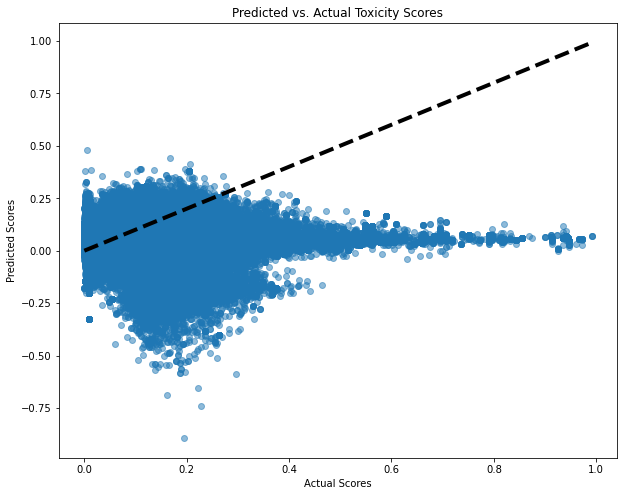

In [87]:
# Assuming 'after_war_doc_toxicity_scores_predicted' are your model's predictions
# and you have actual toxicity scores for 'after_war_documents' in 'after_war_doc_toxicity_scores_actual'
plt.figure(figsize=(10, 8))
plt.scatter(war_and_after_doc_toxicity_scores, predicted_tox_scores, alpha=0.5)
plt.title('Predicted vs. Actual Toxicity Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.plot([war_and_after_doc_toxicity_scores.min(), war_and_after_doc_toxicity_scores.max()], [war_and_after_doc_toxicity_scores.min(), war_and_after_doc_toxicity_scores.max()], 'k--', lw=4)
plt.show()


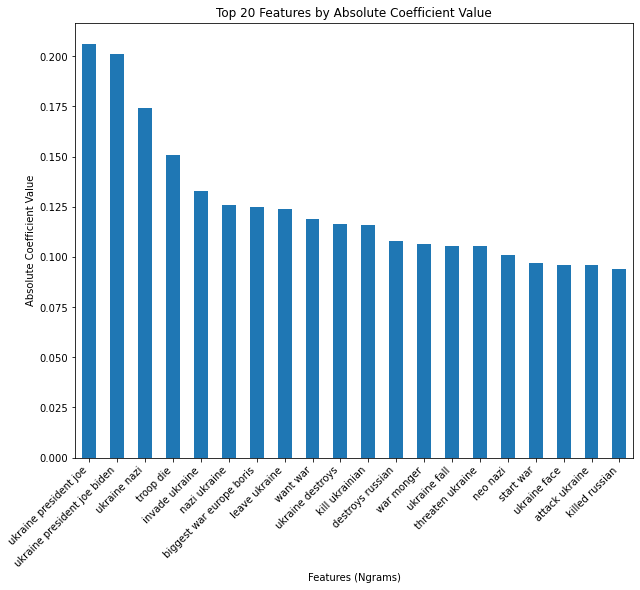

In [85]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LinearRegression model
coefficients = model.coef_
feature_importance = pd.Series(coefficients, index=before_war_feature_names)

# Sort the features by absolute value of their coefficient
sorted_features = feature_importance.abs().sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 8))
sorted_features.plot(kind='bar')
plt.title('Top 20 Features by Absolute Coefficient Value')
plt.ylabel('Absolute Coefficient Value')
plt.xlabel('Features (Ngrams)')
plt.xticks(rotation=45, ha='right')
plt.show()


# Test Detoxify library Examples

In [ ]:
pip install detoxify

In [7]:
test = "shut up you are a liar"
test_scores = detox.predict(test)
print("test scores: ", test_scores)

test scores:  {'toxicity': 0.9841488, 'severe_toxicity': 0.012881926, 'obscene': 0.28888622, 'threat': 0.0023240657, 'insult': 0.83928835, 'identity_attack': 0.00809011}


In [128]:
insult2 = "they deserved to get attacked"
insult_score2 = detox.predict(insult2)
print(" ", insult_score2)

  {'toxicity': 0.9015587, 'severe_toxicity': 0.10870536, 'obscene': 0.05740284, 'threat': 0.8577902, 'insult': 0.09809947, 'identity_attack': 0.11734569}


In [20]:
n_top_words = 100
tf_feature_names = before_war_vect.get_feature_names_out()

topics = dict()
for topic_idx, topic in enumerate(before_war_lda.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % (topic_idx+1))
    print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic #1:
border ukraine | troop border | twitter com | russian troop | troop border ukraine | ukraine crisis | news world | russia nato | nato ukraine | bbc news | want ukraine | nuclear war | russia troop | com news world | world eur | news world eur | russia invaded | weapon ukraine | nato troop | military build | cross border | surrounding ukraine | troop deployed | bbc news world | putin ukraine | foreign minister | com story | soviet union | ukraine need | russia troop border | bbc news world eur | news sky | russia putin | british troop | troop surrounding | threat russia | sky com | avoid war | news sky com | east ukraine | russia invaded ukraine | ukraine like | news sky com story | sky com story | annexed crimea | ukraine troop | ukrainian troop | russia china | baltic state | national security | border say | nord stream | military base | troop defend | ukraine country | troop surrounding ukraine | news ukraine | russian military build | like russia | country russia | ukraine

In [16]:
n_top_words = 20
tf_feature_names = war_and_after_vect.get_feature_names_out()

topics = dict()
for topic_idx, topic in enumerate(war_and_after_lda.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic #%d:" % (topic_idx+1))
    print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic #1:
ukraine russia | ukraine ukraine | invasion ukraine | people ukraine | year old | ukraine ukraineunderattack | russia invasion | russian pow | ukraine incredible | seen russian | incredible video | video seen | lion lion | pow heart | russian pow heart lion | ukraine incredible video seen | seen russian pow | video seen russian pow | ukraine incredible video | pow heart lion
Topic #2:
standwithukraine ukraine | ukraine standwithukraine | russian army | index pointing | backhand index pointing | backhand index | ukraine ukrainian | russian force | blue heart | ukraine russian | yellow heart | russian soldier | united state | situation ukraine | folded hand | ukrainian people | help ukraine | ukraine standwithukraine ukraine | heart yellow | heart yellow heart
Topic #3:
russian invasion | stopputin russianukrainianwar | putinisawarcriminal stopputin russianukrainianwar | standwithukraine ukraineunderattack | terrorussia putinisawarcriminal | terrorussia putinisawarcriminal stop

In [15]:
before_war_ngram = "troop ukraine invasion"
before_war_ngram_tox_score = detox.predict(before_war_ngram)

print(f"{before_war_ngram}: {before_war_ngram_tox_score}")

troop ukraine invasion: {'toxicity': 0.0038996928, 'severe_toxicity': 0.000112767804, 'obscene': 0.00025157433, 'threat': 0.00014708242, 'insult': 0.00023992649, 'identity_attack': 0.0003356948}


In [17]:
after_war_ngram = "putinisawarcriminal stopputin russianukrainianwar "
after_war_ngram_tox_score = detox.predict(before_war_ngram)

print(f"{after_war_ngram}: {after_war_ngram_tox_score}")

putinisawarcriminal stopputin russianukrainianwar : {'toxicity': 0.0038996928, 'severe_toxicity': 0.000112767804, 'obscene': 0.00025157433, 'threat': 0.00014708242, 'insult': 0.00023992649, 'identity_attack': 0.0003356948}


In [19]:

def preprocess_hashtags(text):
    hashtag_pattern = r'#\w+'
    hashtags = re.findall(hashtag_pattern, text)

    for hashtag in hashtags:
        words = re.sub(r'#', '', hashtag).split()
        for word in words:
            text = text.replace(hashtag, word)
    return text

hashtags = "#putinisawarcriminal #stopputin #russianukrainianwar "
sep_hashtags = preprocess_hashtags(hashtags)
print(sep_hashtags)

putinisawarcriminal stopputin russianukrainianwar 


In [22]:
first_5 = before_war_sample[:5]

,,date,text,retweetCount,hashtags,cleaned_text,sentiment_score
cleaned_text,,,,,,,
aa halvor mcfaul question came bottom line talk common solution one hand weakness amp strength russia willing go war keep ukraine nato question worth asking willing go war,829938,2022-01-11,@aas_halvor @McFaul That question came from th...,0,NaN,aa halvor mcfaul question came bottom line tal...,-0.2500
aa neu spaghettikozak dsa intl comm dude even saying saying saying nobody worldwide neocon arguing russia trying invade ukraine defend since wan na talk nazi look founding nato,503548,2022-01-21,@AA_Neu @SpaghettiKozak @DSA_Intl_Comm Dude's ...,0,NaN,aa neu spaghettikozak dsa intl comm dude even ...,-0.4588
aaaaaand nato fluffers enthusiastic war case someone needed proof care ukraine twitter com anders aslund,765045,2022-01-30,Aaaaaand... here's why NATO fluffers are so en...,1,NaN,aaaaaand nato fluffers enthusiastic war case s...,0.3612
aaaaaannndd putin laughing heard ukraine customer mine troop build actually russian base mile border say base ha active year le ha year winking face twitter com murder fancier,293269,2022-02-15,Aaaaaannndd Putin is laughing ... I heard from...,0,NaN,aaaaaannndd putin laughing heard ukraine custo...,0.6124
aadbfs noahpinion step war starting u sending troop seems missing going send troop russian troop start ww stubborn ukraine,589096,2022-02-13,@aadbfs @Noahpinion The steps between a war st...,0,NaN,aadbfs noahpinion step war starting u sending ...,-0.8316
